In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import os 
import gc

sns.set_theme()
pd.set_option('display.max_rows', 200)

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
SEED = 0
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

set_seed(SEED)

In [3]:
data_path = Path("/kaggle/input/vds-news-recommendation")

In [4]:
train = pd.read_parquet(data_path/"train.parquet")
user_profile = pd.read_parquet(data_path/"user_profile.parquet")
article_info = pd.read_parquet(data_path/"article_information.parquet")
private_test = pd.read_parquet(data_path/"private_test.parquet") 

In [5]:
# test = train[train['event_time'].dt.strftime('%Y-%m-%d') == '2022-04-11']
# train = train.drop(test.index)

test = private_test
test['label'] = -1

In [6]:
print(f"num interactions in train: {train.shape[0]}")
print(f"time range: from {train['event_time'].min().__str__()} to {train['event_time'].max().__str__()}")
print(f"num users: {train['user_id'].nunique()}")
print(f"num items: {train['article_id'].nunique()}")
train.head()

num interactions in train: 10120940
time range: from 2022-04-05 23:50:04 to 2022-04-11 23:59:59
num users: 88933
num items: 67107


,user_id,article_id,event_time,label
0,6e4b2ae012590b002f0552a195d03592,f38294602078b144a54267928e2daa1b,2022-04-06 10:56:51,0
1,49937761681b52eb2a17fe87133b7f54,d3db6da84a6e4520122aa72839f83d70,2022-04-07 16:57:09,0
2,86e9d75001cfbe4a94a15a45715a4a90,a53dd8f8d842f275caccd9ce99bde14e,2022-04-11 20:37:58,0
3,68794b2e9c86a8d21fec24182d476147,6ee66eab1744f56b39e42691e88383e5,2022-04-06 20:48:33,0
4,44302cee26c3ba35b3c2d3835d73acf3,9723c867ddf55424175c0eb9d5487d52,2022-04-08 16:06:52,0


In [7]:
print(f"num interactions in test: {test.shape[0]}")
print(f"time range: from {test['event_time'].min().__str__()} to {test['event_time'].max().__str__()}")
print(f"num users: {test['user_id'].nunique()}")
print(f"num items: {test['article_id'].nunique()}")
test.head()

print('-'*60)
num_ano_users = test[~test['user_id'].isin(user_profile['user_id'])]['user_id'].nunique()
num_ano_items = test[~test['article_id'].isin(article_info['article_id'])]['article_id'].nunique()
num_cold_users = test[~test['user_id'].isin(train['user_id'])]['user_id'].nunique()
num_cold_items = test[~test['article_id'].isin(train['article_id'])]['article_id'].nunique()
print(f"""
num anonymous users: {num_ano_users}
num anonymous items: {num_ano_items}
num cold users: {num_cold_users}
num cold items: {num_cold_items}
       """)

print('-'*60)
ite_cold_users = test[~test['user_id'].isin(train['user_id'])]
ite_cold_items = test[~test['article_id'].isin(train['article_id'])]
ite_cold_user_item = ite_cold_users[~ite_cold_users['article_id'].isin(train['article_id'])]
ite_cold_user_or_item = len(ite_cold_users) + len(ite_cold_items) - len(ite_cold_user_item)
print(f"""
num interactions with cold users: {len(ite_cold_users)}
num interactions with cold items: {len(ite_cold_items)}
num interactions with cold users or cold items: {ite_cold_user_or_item}
num interactions with cold users and cold items: {len(ite_cold_user_item)}
       """)

num interactions in test: 1728018
time range: from 2022-04-12 00:00:00 to 2022-04-13 00:09:30
num users: 63085
num items: 27032
------------------------------------------------------------

num anonymous users: 0
num anonymous items: 0
num cold users: 816
num cold items: 8063
       
------------------------------------------------------------

num interactions with cold users: 48448
num interactions with cold items: 572890
num interactions with cold users or cold items: 606262
num interactions with cold users and cold items: 15076
       


In [8]:
print(user_profile.shape)
user_profile.head()

(89762, 4)


,user_id,gender,age,os_name
0,28501fb31cb1999658ce374fccca6812,Male,45-54,windows
1,2366fe0ce31b1f9e0fd38243afe45d90,Female,55-64,windows
2,7a113f19617277f1e7f9348d29123dd7,Male,<18,windows
3,51dad112607b09338ceb9585a9d5f42b,Female,55-64,windows
4,3944c237ce91544babbbafccd127a1eb,Male,55-64,windows


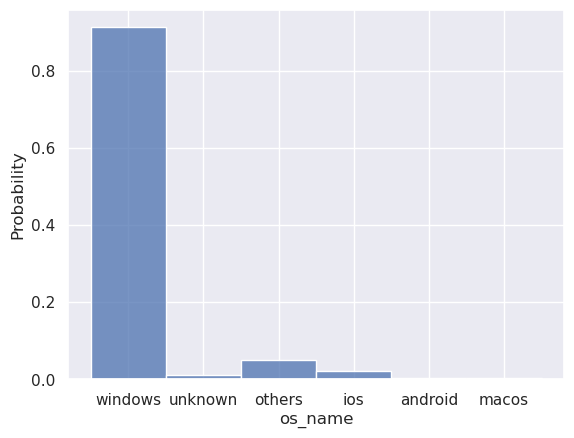

In [9]:
sns.histplot(data=user_profile, x='os_name', stat='probability')
# plt.xticks(rotation='vertical')
plt.show()

In [10]:
print(article_info.shape)
print(f" time range: from {article_info['published_time'].min().__str__()} to"
      f" {article_info['published_time'].max().__str__()}")
article_info.head()

(84066, 5)
 time range: from 2022-04-03 00:00:00 to 2022-04-13 23:59:13


,article_id,published_time,title,domain,category
0,8c4c166c92421fbccee4c9275dad11b7,2022-04-13 10:47:19,"Kỳ Duyên chuẩn “chị đại” khi làm giám khảo, ph...",m.vietgiaitri.com,Giải trí
1,53bc3a9b769782b8ab11b3871e222be0,2022-04-05 15:41:53,Thêm ảnh Lệ Quyên và Hà Hồ “mỗi người mỗi việc...,vietgiaitri.com,None
2,c178534931e45d00ec4044e897bdb8cf,2022-04-12 09:04:00,Cam Lâm (Khánh Hòa) cảnh báo: Phân lô bán nền ...,doanhnghiepvn.vn,Bất động sản
3,76f98c648d161d26c240cd35c315450d,2022-04-07 15:33:00,KHÔNG THỂ TIN NỔI: Poster MV mới của Thiều Bảo...,tiin.vn,Giải trí
4,aeb84e04405bb60fc8fd8caa40d0b875,2022-04-10 04:14:48,Bán vé xem trận giao hữu giữa đội tuyển U23 Vi...,m.tuoitre.vn,Thể thao


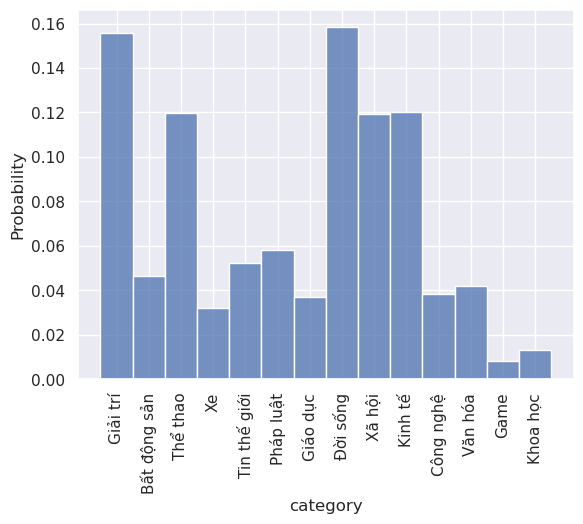

In [11]:
sns.histplot(data=article_info, x='category', stat='probability')
plt.xticks(rotation='vertical')
plt.show()

In [12]:
train = train.merge(user_profile, on='user_id', how='left')
train = train.merge(article_info, on='article_id', how='left')

test = test.merge(user_profile, on='user_id', how='left')
test = test.merge(article_info, on='article_id', how='left')

train = train.drop(columns=['age', 'os_name'])
test = test.drop(columns=['age', 'os_name'])

In [13]:
test

,user_id,article_id,event_time,label,gender,published_time,title,domain,category
0,f1262ea84920d021b6941e31846a9e72,c99e2fc6c3df1b4ce664daecb8701ae7,2022-04-12 19:11:13,-1,Male,2022-04-12 15:28:44,Ông Nguyễn Hồng Điệp: 'Lạm phát đã len lỏi vào...,cafef.vn,Kinh tế
1,f6970cb58c6924483756c34ce8165f4f,452d248b792694d169ed969d8ccb7a6b,2022-04-12 08:34:03,-1,Male,2022-04-05 07:12:00,Đúng 0h ngày 3 3 Âm 4 con giáp chính thức hết ...,kienthuc.net.vn,Đời sống
2,b420264c46da84e1ea39d114ad4616c2,3b69b60332cbf519a1c93054051d1ffd,2022-04-12 07:59:49,-1,Male,2022-04-10 09:00:46,PowerPoint 2019 (Phần 13): Thụt lề và giãn dòng,quantrimang.com,Công nghệ
3,bb8b942b0ec647ebcfd9717894ef0773,8318b17e984c590f762851af65b2c0ef,2022-04-12 14:43:03,-1,Male,2022-04-12 12:02:20,Top 10 game chiến đấu đối kháng hay nhất dành ...,vietgiaitri.com,Game
4,d714e2335a4b391b99c300adbb6b1c32,5f1773f9b5d038a03190b707b06f6844,2022-04-12 14:14:31,-1,Male,2022-04-12 11:24:25,"Biến thể XE là gì, nguy hiểm ra sao, những nướ...",2dep.vn,Đời sống
...,...,...,...,...,...,...,...,...,...
1728013,cded737f6051e4cde5907721bfc2ce2c,786a85f59f2d363d37afc48660bb8570,2022-04-12 05:52:02,-1,Male,2022-04-11 10:01:38,"Việt Nam có loài cá miệng rộng, bắt được 1 con...",24h.com.vn,Khoa học
1728014,0d9f149443d0e4d9b85b67d645a6fc0d,e95421b73ea43b88816c4b921e2a8a7d,2022-04-12 22:40:27,-1,Male,2022-04-11 10:53:00,"Quảng Ngãi: Đầu tư 43,5 tỷ để phát triển, chế ...",etime.danviet.vn,Kinh tế
1728015,30881fed85b60fe775986ba1ae4e6154,efc47ad149799241daaa6662de7b6b10,2022-04-12 11:21:54,-1,Female,2022-04-09 19:10:00,Những phương pháp điều trị viêm đại tràng mang...,congluan.vn,Đời sống
1728016,635dc30c83210e9e514a73327644b5db,6a4afac611135a1218dc14b089e03705,2022-04-12 14:40:50,-1,Male,2022-04-12 08:26:00,Công trình biểu tượng TPHCM có 'áo mới': Bến t...,toquoc.vn,Bất động sản


In [14]:
# impute category 
def infer_category(df):
    article_null_filled = pd.read_json('/kaggle/input/vds-news-embeddings/category.json', orient ='index').reset_index()
    article_null_filled.columns=['article_id', 'category_infer']
    cate_infer = dict(zip(article_null_filled['article_id'].values, article_null_filled['category_infer'].values))
    df['category_infer'] = df['category']
    infer_indices = df[df['category_infer'].isna()].index.values
    df.loc[infer_indices, 'category_infer'] = df.loc[infer_indices, 'article_id'].map(lambda s : cate_infer[s])
    return df['category_infer'].values
train['category_infer'] = infer_category(train[['article_id', 'category']])
test['category_infer'] = infer_category(test[['article_id', 'category']])

train = train.drop(columns=['category'])
test = test.drop(columns=['category'])

In [15]:
# transform domain
train['domain'] = train['domain'].map(lambda x: x[2:] if x[:2] == 'm.' else x)
test['domain'] = test['domain'].map(lambda x: x[2:] if x[:2] == 'm.' else x)

In [16]:
train['event_date'] = train['event_time'].dt.strftime('%Y-%m-%d')
test['event_date'] = test['event_time'].dt.strftime('%Y-%m-%d')
train_stats = train.groupby('event_date').agg({
    'user_id' : 'nunique',
    'article_id' : 'nunique',
    'domain': 'nunique'
})

test_stats = test.groupby('event_date').agg({
    'user_id' : 'nunique',
    'article_id' : 'nunique',
    'domain': 'nunique'
})


In [17]:
train_stats

,user_id,article_id,domain
event_date,,,
2022-04-05,208,498,110
2022-04-06,64813,31402,149
2022-04-07,65171,34169,149
2022-04-08,63225,34579,149
2022-04-09,45841,32595,149
2022-04-10,38364,29720,149
2022-04-11,46100,27348,148


In [18]:
test_stats

,user_id,article_id,domain
event_date,,,
2022-04-12,63085,27024,146
2022-04-13,255,541,110


# Create user features

In [19]:
def create_user_features(df):
    user_features = df.groupby('user_id').agg({
        'user_id': 'count'
    })
    user_features.columns = ['user_impressions']
    user_features = user_features.reset_index()
    return user_features

In [20]:
user_features = create_user_features(pd.concat([train, test]))
train = train.merge(user_features, on=['user_id'], how='left')
test = test.merge(user_features, on=['user_id'], how='left')
del user_features
gc.collect()

8200

# Create item features

In [21]:
def create_item_features(df):
    item_features = df.groupby('article_id').agg({
        'article_id': 'count'
    })
    item_features.columns = ['item_impressions']
    item_features = item_features.reset_index()
    return item_features

In [22]:
item_features = create_item_features(pd.concat([train, test]))
train = train.merge(item_features, on=['article_id'], how='left')
test = test.merge(item_features, on=['article_id'], how='left')
del item_features
gc.collect()

0

# Create user-item features

* period of day (morning, afternoon, evening, night) --> YES
* item-period impressions --> YES
* user-period impressions --> NO
* user-cate read ratio previous day --> NO
* item time since last impression --> NO
* item impressions normalized (by hour) --> YES
* replace item impressions by item date impressions --> YES
* user-cate impression --> YES
* user-cate impression ratio --> YES
* user-cate date impress --> NO
* user-session based
* user-category rank
* user-session read ratio

In [23]:
def create_session(df): # 1 hour gap
    tmp = df[['user_id', 'article_id', 'event_time']].copy()
    tmp = tmp.sort_values(['user_id','event_time'])
    tmp['session'] = tmp.groupby('user_id')['event_time'].diff()
    tmp['session'] = (tmp['session'].dt.total_seconds() > 60*60*1).astype('int8').fillna(0)
    tmp['session'] = tmp.groupby('user_id')['session'].cumsum()
    df = df.merge(tmp, on=['user_id', 'article_id', 'event_time'], how='left')
    return df

train = create_session(train)
test = create_session(test)

In [24]:
tmp = pd.concat([train, test])
gender_count = tmp.groupby(['gender']).size().to_frame('gender_total').reset_index()
gender_cate_impress = tmp.groupby(['gender', 'category_infer']).size().to_frame('gender_cate_impress').reset_index()
gender_cate_impress_rate = gender_cate_impress.merge(gender_count, on=['gender'], how='left')
gender_cate_impress_rate['gender_cate_impress_ratio'] = gender_cate_impress_rate['gender_cate_impress'] / gender_cate_impress_rate['gender_total'] 

gender_cate_impress_rate = gender_cate_impress_rate.drop(columns=['gender_total', 'gender_cate_impress'])
train = train.merge(gender_cate_impress_rate, on=['gender', 'category_infer'], how='left')
test = test.merge(gender_cate_impress_rate, on=['gender', 'category_infer'], how='left')

In [25]:
# train[train['user_id'] == '15a1f05908a36725cc63c419f63609af'].sort_values('event_time')

In [26]:
# test[test['user_id'] == '15a1f05908a36725cc63c419f63609af'].sort_values('event_time')

In [27]:
def create_user_item_features(df):
    df['timestamp'] = (df['event_time'] - df['published_time']).dt.total_seconds()
    df['period'] = pd.cut(df['event_time'].dt.hour,
                         bins=[0, 6, 12, 18, 24],
                         labels=['night', 'morning', 'afternoon', 'evening'],
                         right=False,
                         include_lowest=True)
    df['event_hour'] = df['event_time'].dt.hour
    return df
train = create_user_item_features(train)
test = create_user_item_features(test)

In [28]:
tmp = pd.concat([train, test]).sort_values(['article_id', 'event_time']).drop_duplicates(subset=['article_id'], keep='last')
tmp['item_per_hour_impress'] = tmp['item_impressions'] / (tmp['timestamp'] / 60 / 60)

train = train.merge(tmp[['article_id', 'item_per_hour_impress']], on=['article_id'], how='left')
test = test.merge(tmp[['article_id', 'item_per_hour_impress']], on=['article_id'], how='left')

In [29]:
item_period_impress = pd.concat([train, test]).groupby(['article_id', 'event_date', 'period']).size().to_frame('item_period_impress').reset_index()
train = train.merge(item_period_impress, on=['article_id', 'event_date', 'period'], how='left')
test = test.merge(item_period_impress, on=['article_id', 'event_date', 'period'], how='left')

In [30]:
item_date_impress = pd.concat([train, test]).groupby(['article_id', 'event_date']).size().to_frame('item_date_impress').reset_index()
train = train.merge(item_date_impress, on=['article_id', 'event_date'], how='left')
test = test.merge(item_date_impress, on=['article_id', 'event_date'], how='left')

In [31]:
%%time
# create user reads category ratio col
train = train.sort_values(['user_id', 'event_time'])

train['label_shift'] = train.groupby(['user_id', 'category_infer'])['label'].shift(fill_value=0)
train['cate_impress_count'] = train.groupby(['user_id', 'category_infer'])['label'].cumcount() + 1
train['cate_read'] = train.groupby(['user_id', 'category_infer'])['label_shift'].cumsum().astype('float')
train['user_cate_read_ratio'] = train['cate_read'] / train['cate_impress_count']
train = train.drop(columns=['label_shift', 'cate_impress_count', 'cate_read'])

tmp = train.groupby(['user_id', 'category_infer'])['label'].mean().to_frame('user_cate_read_ratio').reset_index()
test = test.merge(tmp, on=['user_id', 'category_infer'], how='left').fillna(0)

CPU times: user 35.2 s, sys: 2.54 s, total: 37.7 s
Wall time: 37.7 s


In [32]:
%%time
user_cate_impress = pd.concat([train, test]).groupby(['user_id', 'category_infer']).size().to_frame('user_cate_impress').reset_index()
train = train.merge(user_cate_impress, on=['user_id', 'category_infer'], how='left')
test = test.merge(user_cate_impress, on=['user_id', 'category_infer'], how='left')

train['user_cate_impress_ratio'] = train['user_cate_impress'] / train['user_impressions']
test['user_cate_impress_ratio'] = test['user_cate_impress'] / test['user_impressions']


user_cate_period_impress = pd.concat([train, test]).groupby(['user_id', 'category_infer', 'event_date', 'period']).size().to_frame('user_cate_period_impress').reset_index()
train = train.merge(user_cate_period_impress, on=['user_id', 'category_infer', 'event_date', 'period'], how='left')
test = test.merge(user_cate_period_impress, on=['user_id', 'category_infer', 'event_date', 'period'], how='left')

user_cate_session_impress = pd.concat([train, test]).groupby(['user_id', 'category_infer', 'event_date', 'session']).size().to_frame('user_cate_session_impress').reset_index()
train = train.merge(user_cate_session_impress, on=['user_id', 'category_infer', 'event_date', 'session'], how='left')
test = test.merge(user_cate_session_impress, on=['user_id', 'category_infer', 'event_date', 'session'], how='left')

CPU times: user 1min 50s, sys: 37 s, total: 2min 27s
Wall time: 2min 28s


In [33]:
user_domain_impress = pd.concat([train, test]).groupby(['user_id', 'domain']).size().to_frame('user_domain_impress').reset_index()
train = train.merge(user_domain_impress, on=['user_id', 'domain'], how='left')
test = test.merge(user_domain_impress, on=['user_id', 'domain'], how='left')

train['user_domain_impress_ratio'] = train['user_domain_impress'] / train['user_impressions']
test['user_domain_impress_ratio'] = test['user_domain_impress'] / test['user_impressions']

In [34]:
# train[train['user_id'] == '59a3c6254936bf2c5ab70c61096d046b']

In [35]:
# test[test['user_id'] == '906f12987568408b5be1247a862957fc']

# Training

In [36]:
try:
    del train_shuff, X_train, X_test, y_train, y_test
    gc.collect()
except:
    pass
use_cols = ['domain', 'category_infer', 'timestamp', 'period', 'event_hour',
            'item_date_impress', 'item_per_hour_impress', 'item_period_impress', 
            'user_cate_impress', 'user_cate_impress_ratio', 'user_cate_read_ratio',  
            'user_cate_period_impress','user_cate_session_impress',
            'gender_cate_impress_ratio', 'user_domain_impress', 'user_domain_impress_ratio',
            ]
train_shuff = train.sample(frac=1, random_state=SEED)

X_train = train_shuff[use_cols]
X_test = test[use_cols]

y_train = train_shuff['label']
y_test = test['label']

In [37]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Label encoder
le_cols = ['domain', 'category_infer', 'period']
for col in le_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])    

# One-hot encoder
oh_cols = []
for col in oh_cols:
    X_train = pd.concat([X_train, pd.get_dummies(X_train[col])], axis=1).drop(columns=['category_infer'])
    X_test = pd.concat([X_test, pd.get_dummies(X_test[col])], axis=1).drop(columns=['category_infer'])                     

In [38]:
X_train.head()

,domain,category_infer,timestamp,period,event_hour,item_date_impress,item_per_hour_impress,item_period_impress,user_cate_impress,user_cate_impress_ratio,user_cate_read_ratio,user_cate_period_impress,user_cate_session_impress,gender_cate_impress_ratio,user_domain_impress,user_domain_impress_ratio
7104389,87,7,58608.0,1,22,72,2.253247,16,7,0.063063,0.000000,7,7,0.073908,1,0.009009
5361274,92,4,9905.0,2,10,176,5.204646,69,10,0.192308,0.750000,4,4,0.128696,1,0.019231
6472206,135,12,238978.0,0,16,23,1.134193,11,14,0.065728,0.000000,2,1,0.067207,1,0.004695
8377571,64,4,93113.0,2,9,740,15.741736,364,33,0.155660,0.533333,1,1,0.090188,7,0.033019
7544830,64,0,24203.0,1,19,58,3.952236,20,30,0.101010,0.000000,20,20,0.062372,11,0.037037


In [39]:
X_test.head()

,domain,category_infer,timestamp,period,event_hour,item_date_impress,item_per_hour_impress,item_period_impress,user_cate_impress,user_cate_impress_ratio,user_cate_read_ratio,user_cate_period_impress,user_cate_session_impress,gender_cate_impress_ratio,user_domain_impress,user_domain_impress_ratio
0,28,6,13349.0,1,19,22,2.703718,12,28,0.171779,0.807692,2,2,0.065357,9,0.055215
1,64,13,609723.0,2,8,27,0.776201,15,92,0.228288,0.851064,22,22,0.099239,24,0.059553
2,86,1,169143.0,2,7,149,5.007065,47,10,0.054945,0.000000,3,2,0.061825,2,0.010989
3,128,2,9643.0,0,14,460,38.754066,287,10,0.101010,0.000000,2,2,0.062009,9,0.090909
4,3,13,10206.0,0,14,24,1.943976,14,100,0.213675,0.709677,9,8,0.099239,1,0.002137


In [40]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()
xgb_params = {
    'lambda': 0.0010314167451412415,
    'alpha': 0.012214121398278847,
    'colsample_bytree': 0.5,
    'subsample': 0.9,
    'learning_rate': 0.1,
    'n_estimators': 620,
    'max_depth': 9,
    'random_state': 11,
    'min_child_weight': 70,
#     'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'tree_method': 'gpu_hist',
    'n_jobs': -1,
}
model = XGBClassifier(**xgb_params)
# model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=50) --> for local validation
model.fit(X_train, y_train, verbose=50) # --> for private test submission

XGBClassifier(alpha=0.012214121398278847, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.0010314167451412415,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=70, missing=nan,
              monotone_constraints=None, n_estimators=620, n_jobs=-1,
              num_parallel_tree=None, ...)

# Inference

In [41]:
preds = model.predict_proba(X_test)[:, 1]

In [42]:
preds

array([0.9986008 , 0.9993761 , 0.00877457, ..., 0.01469368, 0.15553807,
       0.16669089], dtype=float32)

In [43]:
sub = pd.DataFrame({
    'pred' : preds,
    'label': y_test
})
compression_opts = dict(method='zip', archive_name='results.csv')
# sub.to_csv('xgb_valid.csv', index=False)
sub.to_csv('xgb_test.csv', index=False)
sub[['pred']].to_csv('results.zip', header=False, index=False, compression=compression_opts)

In [44]:
sub[['pred']]

,pred
0,0.998601
1,0.999376
2,0.008775
3,0.071629
4,0.541142
...,...
1728013,0.969256
1728014,0.010082
1728015,0.014694
1728016,0.155538


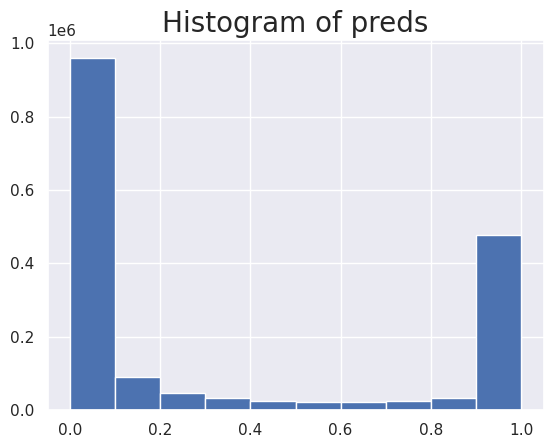

In [45]:
import matplotlib.pyplot as plt
plt.hist(sub['pred'], bins=10)
plt.title('Histogram of preds',size=20)
plt.show()